In [1]:
# =======================
# 1. Install & Import
# =======================
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

print("✅ All libraries imported successfully!")

2025-11-15 01:38:49.402353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763170729.610575      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763170729.667041      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✅ All libraries imported successfully!


In [2]:
# =======================
# 2. Dataset Paths (Kaggle)
# =======================
train_dir = "/kaggle/input/fishmargedataset/margeDataset/train"
val_dir   = "/kaggle/input/fishmargedataset/margeDataset/valid"
test_dir  = "/kaggle/input/fishmargedataset/margeDataset/test"

In [3]:
# =======================
# 3. Data Generators
# =======================
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
class_names = list(train_gen.class_indices.keys())
print("✅ Found classes:", class_names)

Found 20597 images belonging to 20 classes.
Found 5885 images belonging to 20 classes.
Found 2943 images belonging to 20 classes.
✅ Found classes: ['Aair', 'Boal', 'Chapila', 'Foli', 'Ilish', 'KalBaush', 'Katla', 'Koi', 'Magur', 'Mrigel', 'Pabda', 'Pangas', 'Puti', 'Rui', 'Shol', 'SorPuti', 'Taki', 'Tarabaim', 'Telapiya', 'Tengra']


In [4]:
# =======================
#  Show Image Counts (Before & After Augmentation)
# =======================

def count_images_in_dir(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                count += 1
    return count

train_count_before = count_images_in_dir(train_dir)
val_count_before   = count_images_in_dir(val_dir)
test_count_before  = count_images_in_dir(test_dir)

print("\n===============================")
print("📸 IMAGE COUNT SUMMARY")
print("===============================")
print(f"Original Training images:   {train_count_before}")
print(f"Original Validation images: {val_count_before}")
print(f"Original Testing images:    {test_count_before}")
print("-------------------------------")
print(f"Train Generator samples:    {train_gen.samples}")
print(f"Val Generator samples:      {val_gen.samples}")
print(f"Test Generator samples:     {test_gen.samples}")



📸 IMAGE COUNT SUMMARY
Original Training images:   20597
Original Validation images: 5885
Original Testing images:    2943
-------------------------------
Train Generator samples:    20597
Val Generator samples:      5885
Test Generator samples:     2943


In [5]:
# =======================
# 4. Paths Setup
# =======================
base_dir = "/kaggle/working/densenet121"
os.makedirs(base_dir, exist_ok=True)

model_path = os.path.join(base_dir, "densenet121_best.h5")
final_model_path = os.path.join(base_dir, "densenet121_final.h5")
log_path = os.path.join(base_dir, "densenet121_training_log.csv")

# =======================
# 5. Build or Load Model (DenseNet121)
# =======================
if os.path.exists(model_path):
    print("🔹 Loading previous best model...")
    model = load_model(model_path)
else:
    print("🔹 Building new DenseNet121 model...")

    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False  # freeze base layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

model.summary()

🔹 Building new DenseNet121 model...


I0000 00:00:1763170790.508310      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,305,044 (27.87 MB)

 Trainable params: 267,540 (1.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [6]:
# =======================
# 6. Callbacks
# =======================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
csv_logger = CSVLogger(log_path, append=True)
checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [7]:
# =======================
# 7. Train Model (Phase 1)
# =======================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, csv_logger, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1763170845.981327     126 service.cc:148] XLA service 0x7f4afc003890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763170845.982096     126 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763170848.913335     126 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/644 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.1172 - loss: 3.3815   

I0000 00:00:1763170860.185554     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.2820 - loss: 2.4528
Epoch 1: val_loss improved from inf to 0.88589, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 527s 777ms/step - accuracy: 0.2823 - loss: 2.4519 - val_accuracy: 0.7971 - val_loss: 0.8859
Epoch 2/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.6928 - loss: 1.0512
Epoch 2: val_loss improved from 0.88589 to 0.49856, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 319s 496ms/step - accuracy: 0.6929 - loss: 1.0510 - val_accuracy: 0.8828 - val_loss: 0.4986
Epoch 3/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.7975 - loss: 0.7010
Epoch 3: val_loss improved from 0.49856 to 0.35160, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 319s 495ms/step - accuracy: 0.7975 - loss: 0.7009 - val_accuracy: 0.9147 - val_loss: 0.3516
Epoch 4/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8429 - loss: 0.5386
Epoch 4: val_loss improved from 0.35160 to 0.28644, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 320s 497ms/step - accuracy: 0.8429 - loss: 0.5386 - val_accuracy: 0.9298 - val_loss: 0.2864
Epoch 5/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8700 - loss: 0.4478
Epoch 5: val_loss improved from 0.28644 to 0.23573, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 317s 493ms/step - accuracy: 0.8700 - loss: 0.4478 - val_accuracy: 0.9402 - val_loss: 0.2357
Epoch 6/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8901 - loss: 0.3834
Epoch 6: val_loss improved from 0.23573 to 0.20615, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 320s 496ms/step - accuracy: 0.8901 - loss: 0.3834 - val_accuracy: 0.9468 - val_loss: 0.2062
Epoch 7/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8978 - loss: 0.3419
Epoch 7: val_loss improved from 0.20615 to 0.18157, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 319s 495ms/step - accuracy: 0.8978 - loss: 0.3419 - val_accuracy: 0.9531 - val_loss: 0.1816
Epoch 8/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9165 - loss: 0.2973
Epoch 8: val_loss improved from 0.18157 to 0.16689, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 320s 497ms/step - accuracy: 0.9165 - loss: 0.2973 - val_accuracy: 0.9546 - val_loss: 0.1669
Epoch 9/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9189 - loss: 0.2768
Epoch 9: val_loss improved from 0.16689 to 0.14758, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 316s 491ms/step - accuracy: 0.9189 - loss: 0.2768 - val_accuracy: 0.9621 - val_loss: 0.1476
Epoch 10/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9212 - loss: 0.2573
Epoch 10: val_loss improved from 0.14758 to 0.13725, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 317s 492ms/step - accuracy: 0.9212 - loss: 0.2573 - val_accuracy: 0.9655 - val_loss: 0.1372
Epoch 11/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9347 - loss: 0.2268
Epoch 11: val_loss improved from 0.13725 to 0.13056, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 321s 498ms/step - accuracy: 0.9347 - loss: 0.2268 - val_accuracy: 0.9658 - val_loss: 0.1306
Epoch 12/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9341 - loss: 0.2248
Epoch 12: val_loss improved from 0.13056 to 0.12219, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 317s 492ms/step - accuracy: 0.9341 - loss: 0.2248 - val_accuracy: 0.9675 - val_loss: 0.1222
Epoch 13/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9377 - loss: 0.2072
Epoch 13: val_loss improved from 0.12219 to 0.11076, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 316s 491ms/step - accuracy: 0.9377 - loss: 0.2072 - val_accuracy: 0.9692 - val_loss: 0.1108
Epoch 14/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9394 - loss: 0.2002
Epoch 14: val_loss improved from 0.11076 to 0.10745, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 318s 494ms/step - accuracy: 0.9394 - loss: 0.2002 - val_accuracy: 0.9708 - val_loss: 0.1074
Epoch 15/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9446 - loss: 0.1838
Epoch 15: val_loss improved from 0.10745 to 0.10071, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 318s 494ms/step - accuracy: 0.9446 - loss: 0.1837 - val_accuracy: 0.9733 - val_loss: 0.1007
Epoch 16/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9482 - loss: 0.1742
Epoch 16: val_loss improved from 0.10071 to 0.09421, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 326s 506ms/step - accuracy: 0.9482 - loss: 0.1742 - val_accuracy: 0.9730 - val_loss: 0.0942
Epoch 17/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9512 - loss: 0.1644
Epoch 17: val_loss did not improve from 0.09421
644/644 ━━━━━━━━━━━━━━━━━━━━ 319s 495ms/step - accuracy: 0.9512 - loss: 0.1644 - val_accuracy: 0.9742 - val_loss: 0.0955
Epoch 18/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9532 - loss: 0.1590
Epoch 18: val_loss improved from 0.09421 to 0.08832, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 319s 496ms/step - accuracy: 0.9532 - loss: 0.1590 - val_accuracy: 0.9750 - val_loss: 0.0883
Epoch 19/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9529 - loss: 0.1501
Epoch 19: val_loss improved from 0.08832 to 0.08380, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 319s 495ms/step - accuracy: 0.9529 - loss: 0.1501 - val_accuracy: 0.9781 - val_loss: 0.0838
Epoch 20/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9604 - loss: 0.1361
Epoch 20: val_loss improved from 0.08380 to 0.08248, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 317s 492ms/step - accuracy: 0.9604 - loss: 0.1361 - val_accuracy: 0.9771 - val_loss: 0.0825
Epoch 21/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9577 - loss: 0.1394
Epoch 21: val_loss improved from 0.08248 to 0.07631, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 316s 491ms/step - accuracy: 0.9577 - loss: 0.1394 - val_accuracy: 0.9781 - val_loss: 0.0763
Epoch 22/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9599 - loss: 0.1333
Epoch 22: val_loss did not improve from 0.07631
644/644 ━━━━━━━━━━━━━━━━━━━━ 320s 498ms/step - accuracy: 0.9599 - loss: 0.1333 - val_accuracy: 0.9774 - val_loss: 0.0807
Epoch 23/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9625 - loss: 0.1283
Epoch 23: val_loss improved from 0.07631 to 0.07451, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 321s 498ms/step - accuracy: 0.9625 - loss: 0.1283 - val_accuracy: 0.9774 - val_loss: 0.0745
Epoch 24/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9638 - loss: 0.1208
Epoch 24: val_loss did not improve from 0.07451
644/644 ━━━━━━━━━━━━━━━━━━━━ 322s 500ms/step - accuracy: 0.9638 - loss: 0.1208 - val_accuracy: 0.9759 - val_loss: 0.0808
Epoch 25/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9665 - loss: 0.1133
Epoch 25: val_loss improved from 0.07451 to 0.07173, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 322s 500ms/step - accuracy: 0.9665 - loss: 0.1133 - val_accuracy: 0.9789 - val_loss: 0.0717
Epoch 26/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9636 - loss: 0.1178
Epoch 26: val_loss improved from 0.07173 to 0.06993, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 319s 496ms/step - accuracy: 0.9636 - loss: 0.1178 - val_accuracy: 0.9794 - val_loss: 0.0699
Epoch 27/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9690 - loss: 0.1076
Epoch 27: val_loss did not improve from 0.06993
644/644 ━━━━━━━━━━━━━━━━━━━━ 323s 502ms/step - accuracy: 0.9690 - loss: 0.1076 - val_accuracy: 0.9798 - val_loss: 0.0700
Epoch 28/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9692 - loss: 0.1068
Epoch 28: val_loss did not improve from 0.06993
644/644 ━━━━━━━━━━━━━━━━━━━━ 330s 512ms/step - accuracy: 0.9692 - loss: 0.1068 - val_accuracy: 0.9788 - val_loss: 0.0701
Epoch 29/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9683 - loss: 0.1098
Epoch 29: val_loss improved from 0.06993 to 0.06547, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 331s 513ms/step - accuracy: 0.9683 - loss: 0.1098 - val_accuracy: 0.9794 - val_loss: 0.0655
Epoch 30/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9684 - loss: 0.1076
Epoch 30: val_loss improved from 0.06547 to 0.06435, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 327s 508ms/step - accuracy: 0.9684 - loss: 0.1076 - val_accuracy: 0.9810 - val_loss: 0.0643


In [8]:
# =======================
# 8. Fine-Tune (Phase 2)
# =======================
print("🔹 Fine-tuning last 60 layers of DenseNet121...")
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, csv_logger, checkpoint]
)

🔹 Fine-tuning last 60 layers of DenseNet121...
Epoch 1/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8933 - loss: 0.3379
Epoch 1: val_loss did not improve from 0.06435
644/644 ━━━━━━━━━━━━━━━━━━━━ 395s 555ms/step - accuracy: 0.8933 - loss: 0.3378 - val_accuracy: 0.9730 - val_loss: 0.0835
Epoch 2/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9524 - loss: 0.1511
Epoch 2: val_loss did not improve from 0.06435
644/644 ━━━━━━━━━━━━━━━━━━━━ 322s 500ms/step - accuracy: 0.9524 - loss: 0.1511 - val_accuracy: 0.9760 - val_loss: 0.0715
Epoch 3/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9595 - loss: 0.1254
Epoch 3: val_loss improved from 0.06435 to 0.06212, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 321s 498ms/step - accuracy: 0.9595 - loss: 0.1254 - val_accuracy: 0.9788 - val_loss: 0.0621
Epoch 4/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9609 - loss: 0.1214
Epoch 4: val_loss improved from 0.06212 to 0.05601, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 318s 493ms/step - accuracy: 0.9609 - loss: 0.1214 - val_accuracy: 0.9808 - val_loss: 0.0560
Epoch 5/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9685 - loss: 0.1026
Epoch 5: val_loss improved from 0.05601 to 0.05182, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 319s 496ms/step - accuracy: 0.9685 - loss: 0.1026 - val_accuracy: 0.9825 - val_loss: 0.0518
Epoch 6/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9718 - loss: 0.0931
Epoch 6: val_loss improved from 0.05182 to 0.04882, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 316s 490ms/step - accuracy: 0.9718 - loss: 0.0931 - val_accuracy: 0.9835 - val_loss: 0.0488
Epoch 7/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9726 - loss: 0.0867
Epoch 7: val_loss improved from 0.04882 to 0.04665, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 319s 496ms/step - accuracy: 0.9726 - loss: 0.0867 - val_accuracy: 0.9842 - val_loss: 0.0467
Epoch 8/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9727 - loss: 0.0847
Epoch 8: val_loss improved from 0.04665 to 0.04371, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 320s 497ms/step - accuracy: 0.9727 - loss: 0.0847 - val_accuracy: 0.9845 - val_loss: 0.0437
Epoch 9/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9783 - loss: 0.0729
Epoch 9: val_loss improved from 0.04371 to 0.04209, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 322s 500ms/step - accuracy: 0.9783 - loss: 0.0729 - val_accuracy: 0.9864 - val_loss: 0.0421
Epoch 10/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9785 - loss: 0.0701
Epoch 10: val_loss improved from 0.04209 to 0.04015, saving model to /kaggle/working/densenet121/densenet121_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 320s 498ms/step - accuracy: 0.9785 - loss: 0.0701 - val_accuracy: 0.9866 - val_loss: 0.0401


In [9]:
# =======================
# 9. Save Final Model
# =======================
model.save(final_model_path)
print(f"✅ Final model saved to: {final_model_path}")

✅ Final model saved to: /kaggle/working/densenet121/densenet121_final.h5


In [10]:
# =======================
# 10. Evaluate on Test Data
# =======================
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\n✅ Testing Accuracy : {test_acc*100:.2f}%")
print(f"✅ Testing Loss     : {test_loss:.4f}")

# =======================
#  Evaluate on Validation Data
# =======================
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"\n✅ Validation Accuracy : {val_acc*100:.2f}%")
print(f"✅ Validation Loss     : {val_loss:.4f}")

# =======================
# . Evaluate on train Data
# =======================
train_loss, train_acc = model.evaluate(train_gen, verbose=1)
print(f"\n✅ Train Accuracy : {train_acc*100:.2f}%")
print(f"✅ Train Loss     : {train_loss:.4f}")

92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 489ms/step - accuracy: 0.9836 - loss: 0.0583

✅ Testing Accuracy : 98.57%
✅ Testing Loss     : 0.0489
184/184 ━━━━━━━━━━━━━━━━━━━━ 31s 169ms/step - accuracy: 0.9853 - loss: 0.0444

✅ Validation Accuracy : 98.66%
✅ Validation Loss     : 0.0401
644/644 ━━━━━━━━━━━━━━━━━━━━ 294s 457ms/step - accuracy: 0.9940 - loss: 0.0248

✅ Train Accuracy : 99.39%
✅ Train Loss     : 0.0242


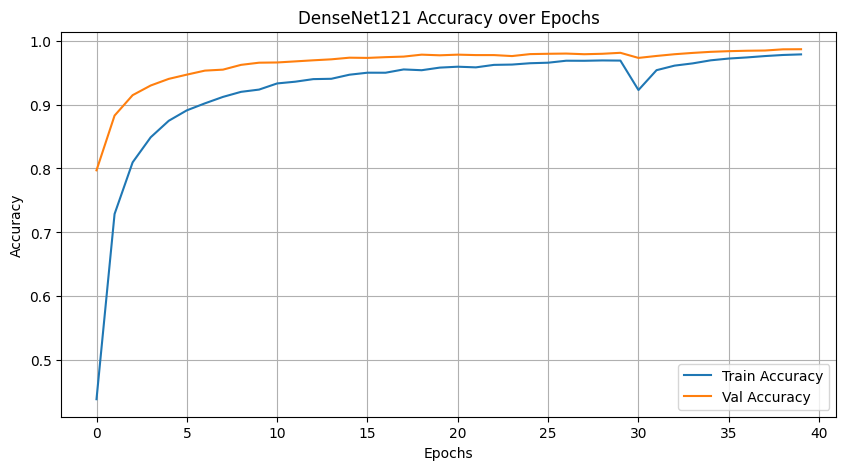

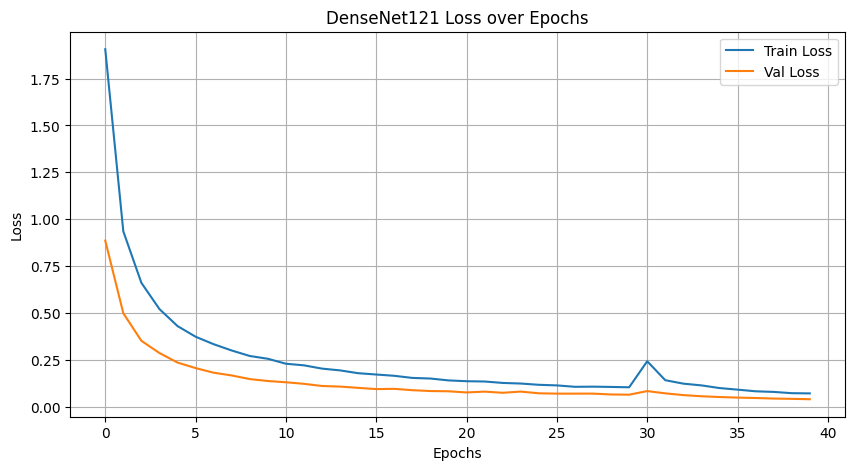

In [11]:
# =======================
# 11. Plot Training History
# =======================
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('DenseNet121 Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('DenseNet121 Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# =======================
# 12. Predictions & Evaluation
# =======================
y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print("\n📊 Classification Report:\n")
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    digits=4
))

92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step

📊 Classification Report:

              precision    recall  f1-score   support

        Aair     0.9945    0.9837    0.9891       184
        Boal     0.9822    0.9822    0.9822       169
     Chapila     0.9839    0.9839    0.9839        62
        Foli     1.0000    0.9846    0.9922        65
       Ilish     1.0000    1.0000    1.0000       116
    KalBaush     0.9697    0.9796    0.9746        98
       Katla     0.9781    0.9676    0.9728       185
         Koi     1.0000    0.9474    0.9730        95
       Magur     0.9726    0.9595    0.9660        74
      Mrigel     1.0000    0.9839    0.9919       186
       Pabda     0.9848    0.9949    0.9898       196
      Pangas     0.9725    0.9907    0.9815       107
        Puti     0.9943    0.9943    0.9943       174
         Rui     0.9624    0.9961    0.9790       257
        Shol     0.9817    0.9877    0.9847       163
     SorPuti     1.0000    0.9787    0.9892        47
        Taki

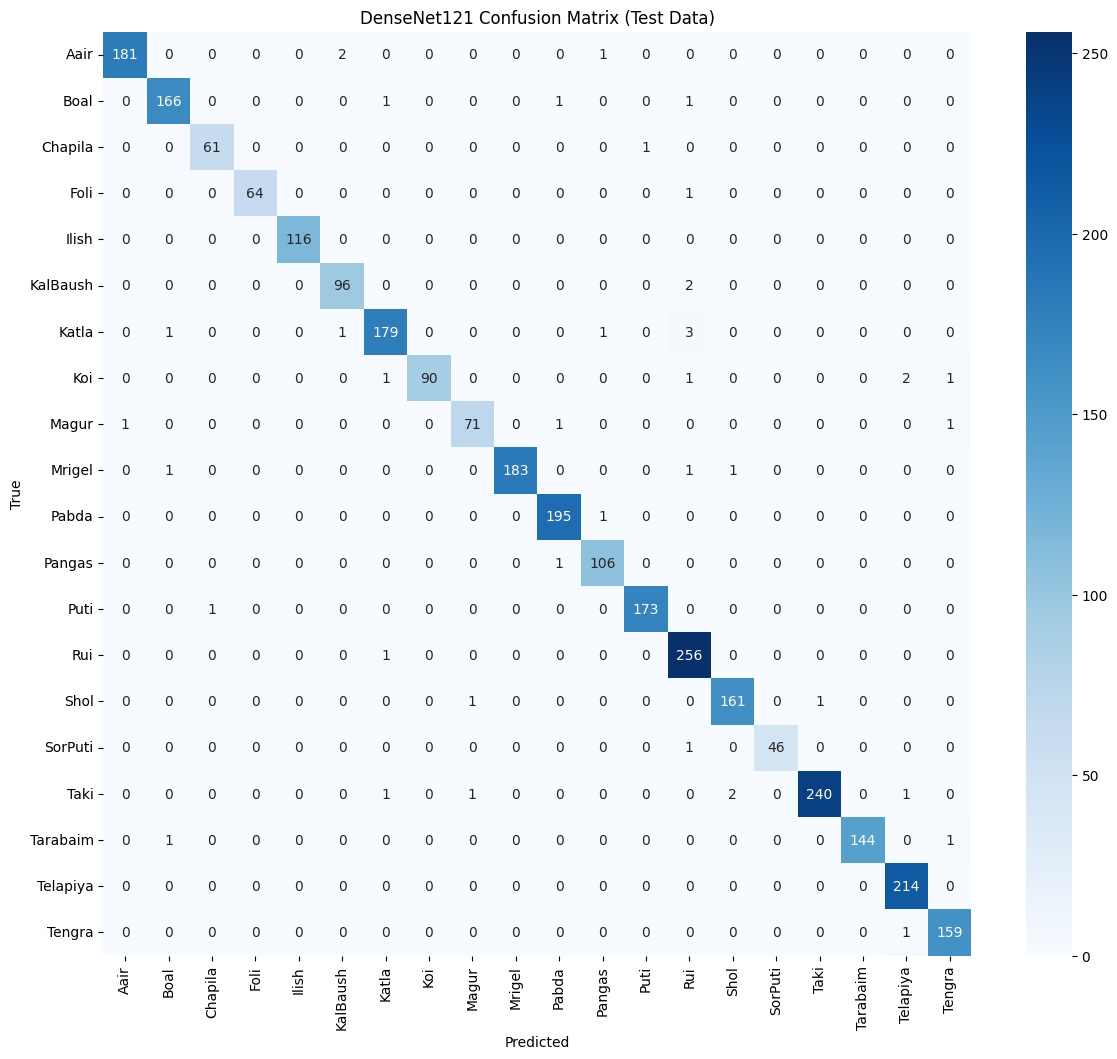

In [13]:
# =======================
# 13. Confusion Matrix
# =======================
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DenseNet121 Confusion Matrix (Test Data)")
plt.show()


📊 Per-Class Metrics:

          Precision  Recall  F1-Score
Class                                
Aair         0.9945  0.9837    0.9891
Boal         0.9822  0.9822    0.9822
Chapila      0.9839  0.9839    0.9839
Foli         1.0000  0.9846    0.9922
Ilish        1.0000  1.0000    1.0000
KalBaush     0.9697  0.9796    0.9746
Katla        0.9781  0.9676    0.9728
Koi          1.0000  0.9474    0.9730
Magur        0.9726  0.9595    0.9660
Mrigel       1.0000  0.9839    0.9919
Pabda        0.9848  0.9949    0.9898
Pangas       0.9725  0.9907    0.9815
Puti         0.9943  0.9943    0.9943
Rui          0.9624  0.9961    0.9790
Shol         0.9817  0.9877    0.9847
SorPuti      1.0000  0.9787    0.9892
Taki         0.9959  0.9796    0.9877
Tarabaim     1.0000  0.9863    0.9931
Telapiya     0.9817  1.0000    0.9907
Tengra       0.9815  0.9938    0.9876


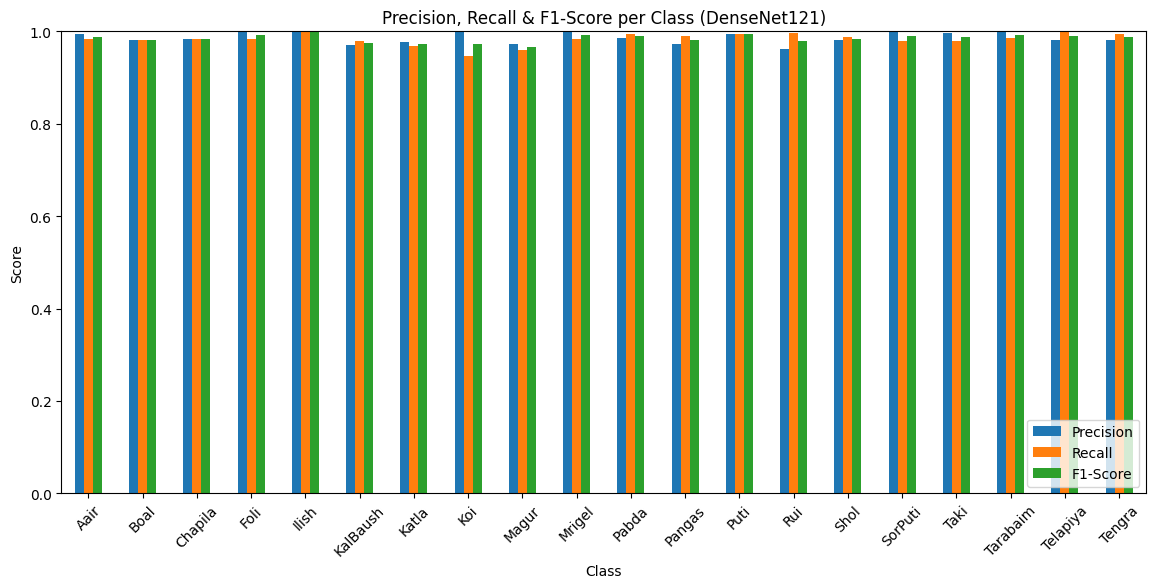

In [14]:
# =======================
# 14. Precision, Recall, F1
# =======================
precision = precision_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))
recall    = recall_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))
f1        = f1_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}).set_index('Class')

print("\n📊 Per-Class Metrics:\n")
print(metrics_df.round(4))

metrics_df.plot(kind='bar', figsize=(14,6))
plt.title("Precision, Recall & F1-Score per Class (DenseNet121)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


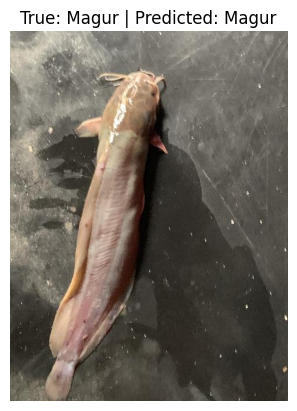

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


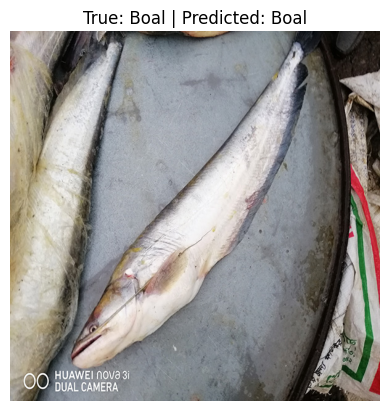

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


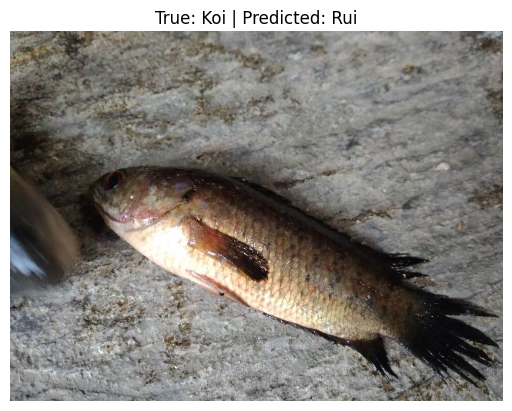

In [15]:
# =======================
# 16. Random Test Predictions
# =======================
def predict_random_image(test_dir, model, class_names, img_size=(224,224)):
    random_class = random.choice(os.listdir(test_dir))
    class_path = os.path.join(test_dir, random_class)
    random_img = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, random_img)

    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred)]
    true_class = random_class

    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.axis("off")
    plt.title(f"True: {true_class} | Predicted: {pred_class}")
    plt.show()

for i in range(3):
    predict_random_image(test_dir, model, class_names)